In [29]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms

import torch.nn as nn
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler

# Hyper Parameters
num_epochs = 1000
# batch_size = 128
learning_rate = 0.001

# Used for splitting data into validation and training set

def validationSplit(trainset, ratio=0.1):
    trainlen = len(trainset)
    indices = list(range(trainlen))
    split = int(np.floor(ratio*trainlen))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)    
    return train_sampler, valid_sampler

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                       download=False, transform=transform)

train_sampler, valid_sampler = validationSplit(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler,
                                          num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=len(valid_sampler),
                                               sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [44]:
import torch.nn.functional as F
import torch.nn.init as init

class Net(nn.Module):            
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.initWeights()
        
    def initWeights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()
net.cuda()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)

In [19]:
torch.save(net.state_dict(), 'lenetadamoptimizer.pkl')

In [46]:
print(net.eval)

<bound method Module.eval of Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (400 -> 120)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear (120 -> 84)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear (84 -> 10)
)>


In [50]:
import sys
testLoss = []
valLoss = []
trainLoss = []
testAcc = []
valAcc = []
trainAcc = []
prevValLoss = sys.maxsize
stopCount = 0
stopEpochs = False

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    runcount = 0
    val_loss = 0.0
    valcount = 0
    test_loss = 0.0
    testcount = 0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        runcount += 1
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cuda() == labels.data).sum()
    if(epoch%10==0):
        print('[%d] training loss: %.3f' %
                      (epoch + 1, running_loss / runcount))
        print('[%d] training accuracy: %.3f' %
                      (epoch + 1, 100 * correct / total))
    trainLoss.append(running_loss / runcount)
    trainAcc.append(100 * correct / total)
    correct = 0
    total = 0
    
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.data[0]
        valcount += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cuda() == labels.data).sum()
    valloss = val_loss/valcount
    if(prevValLoss<valloss):
        stopCount += 1
        if(stopCount>=5):
            stopEpochs = True
    else:
        stopCount = 0
    prevValLoss = valloss
    if(epoch%10==0):
        print('[%d] validation loss: %.3f' %
                      (epoch + 1, valloss))
        print('[%d] validation accuracy: %.3f' %
                      (epoch + 1, 100 * correct / total))
    valLoss.append(valloss)
    valAcc.append(100 * correct / total)
    correct = 0
    total = 0
    
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.data[0]
        testcount += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cuda() == labels.data).sum()
    
    if(epoch%10==0):
        print('[%d] test loss: %.3f' %
                      (epoch + 1, test_loss / testcount))
        print('[%d] test accuracy: %.3f' %
                      (epoch + 1, 100 * correct / total))
    testLoss.append(test_loss / testcount)
    testAcc.append(100 * correct / total)
    if(stopEpochs):
        break
    
print('Finished Training')

plt.title("LeNet")
plt.plot(trainLoss, label="Train", color='blue')
plt.plot(valLoss, label="Validation", color='green')
plt.plot(testLoss, label="Test", color='red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()

plt.title("LeNet")
plt.plot(trainAcc, label="Train", color='blue')
plt.plot(valAcc, label="Validation", color='green')
plt.plot(testAcc, label="Test", color='red')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.legend()
plt.show()

[1] training loss: 0.547
[1] training accuracy: 80.780
[1] validation loss: 0.912
[1] validation accuracy: 69.460
[1] test loss: 0.956
[1] test accuracy: 68.520
[11] training loss: 0.528
[11] training accuracy: 81.458
[11] validation loss: 0.895
[11] validation accuracy: 69.860
[11] test loss: 0.966
[11] test accuracy: 68.360
[21] training loss: 0.518
[21] training accuracy: 81.660
[21] validation loss: 0.921
[21] validation accuracy: 69.600
[21] test loss: 0.979
[21] test accuracy: 68.620
[31] training loss: 0.507
[31] training accuracy: 82.020
[31] validation loss: 0.923
[31] validation accuracy: 70.180
[31] test loss: 0.974
[31] test accuracy: 68.720
[41] training loss: 0.497
[41] training accuracy: 82.560
[41] validation loss: 0.948
[41] validation accuracy: 69.240
[41] test loss: 0.982
[41] test accuracy: 67.950
[51] training loss: 0.488
[51] training accuracy: 82.542
[51] validation loss: 0.975
[51] validation accuracy: 69.000
[51] test loss: 1.007
[51] test accuracy: 67.660
[61]

Process Process-3598:
KeyboardInterrupt
Process Process-3597:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line

KeyboardInterrupt: 

  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/site-packages/torchvision-0.1.9-py3.5.egg/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = Image.fromarray(img)
  File "/opt/conda/lib/python3.5/site-packages/torchvision-0.1.9-py3.5.egg/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = Image.fromarray(img)
  File "/opt/conda/lib/python3.5/site-packages/PIL/Image.py", line 2434, in fromarray
    obj = obj.tobytes()
  File "/opt/conda/lib/python3.5/site-packages/PIL/Image.py", line 2434, in fromarray
    obj = obj.tobytes()
KeyboardInterrupt


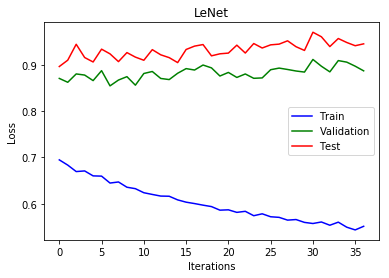

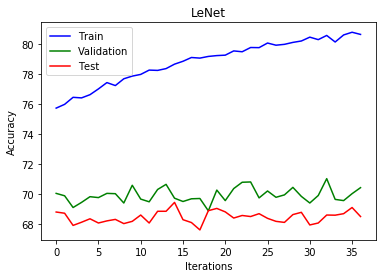

In [49]:

plt.title("LeNet")
plt.plot(trainLoss, label="Train", color='blue')
plt.plot(valLoss, label="Validation", color='green')
plt.plot(testLoss, label="Test", color='red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()

plt.title("LeNet")
plt.plot(trainAcc, label="Train", color='blue')
plt.plot(valAcc, label="Validation", color='green')
plt.plot(testAcc, label="Test", color='red')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.legend()
plt.show()